In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sps as sps
import lbg_forecast.sfh as sfh
import lbg_forecast.priors as pr
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.zhistory as zh
import lbg_forecast.priors as pr
import lbg_forecast.noise as noise
import lbg_forecast.selection as sel
import lbg_forecast.nz_sim as nz

import getdist
from getdist import plots, MCSamples

In [3]:
#sps_model = sps.initialise_sps_model(neb_em=False)

In [4]:
hyperparameter_mu_bounds, hyperparameter_sigma_max = hyp.default_hyperparameter_bounds()

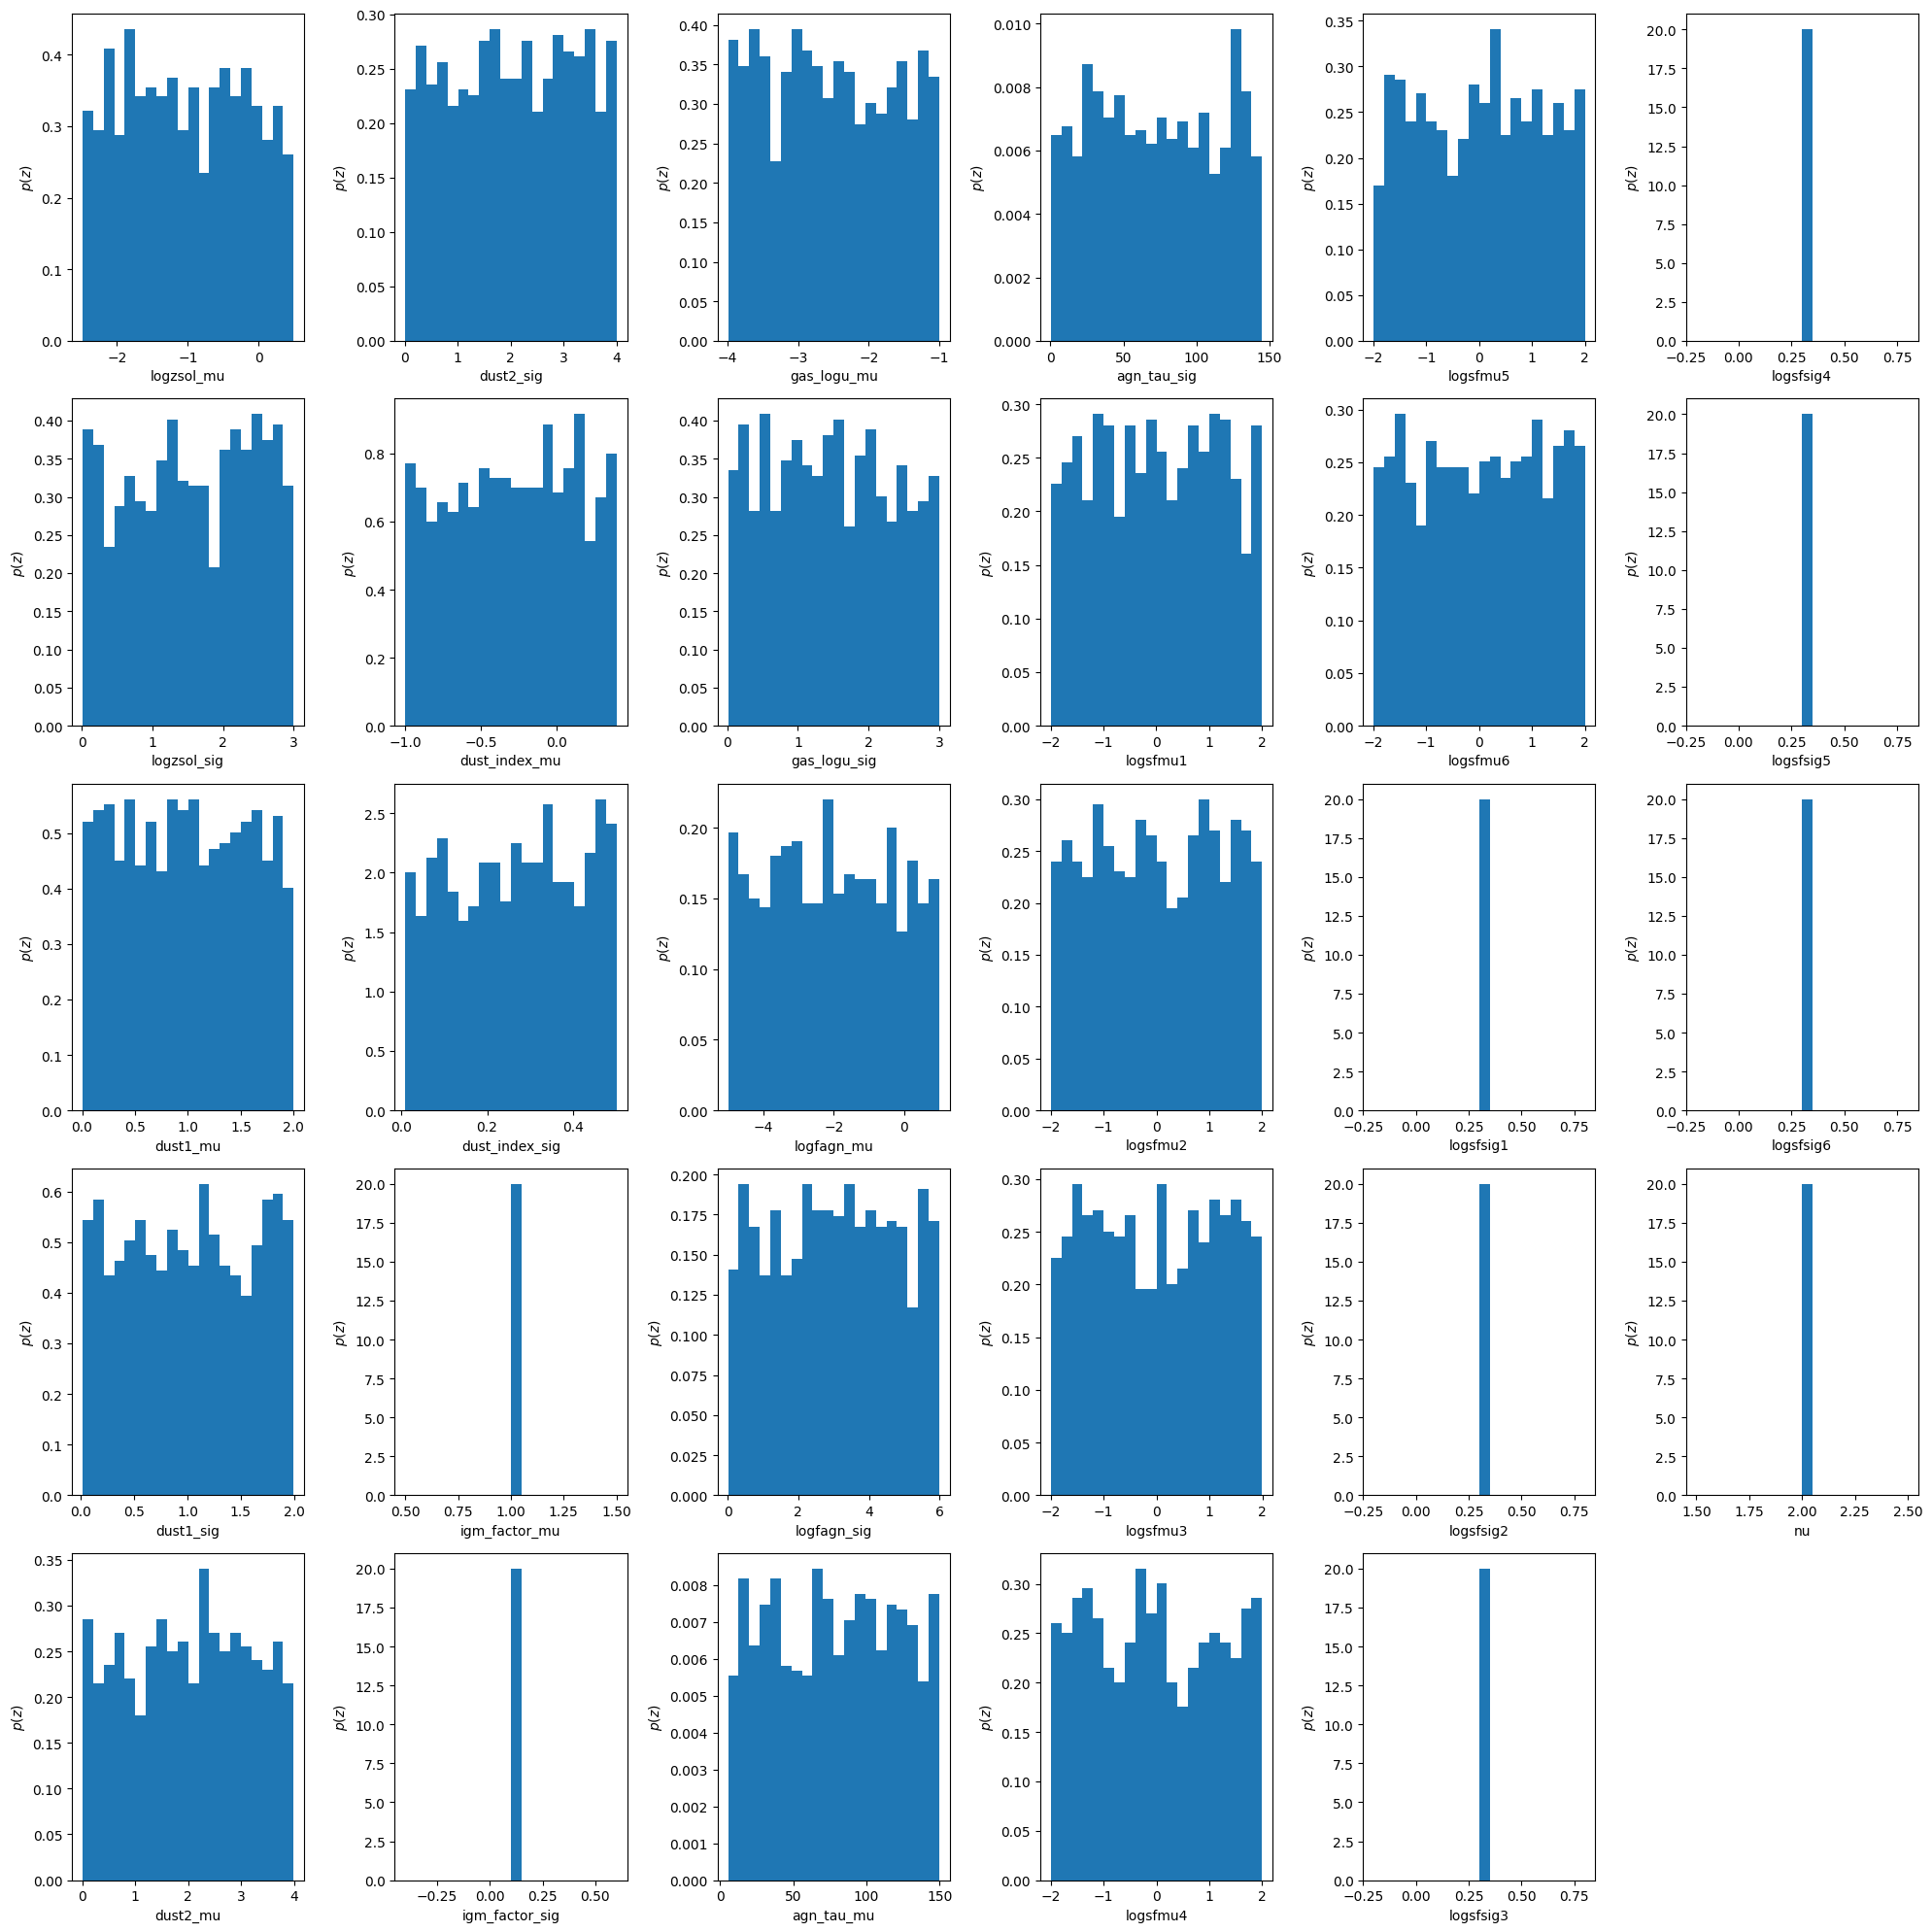

In [5]:
prior_parameters = hyp.sample_prior_parameters(1000, hyperparameter_mu_bounds, hyperparameter_sigma_max)
hyp.plot_hyperparameters(prior_parameters)

In [6]:
redshift_mass_prior_parameters = pr.setup_redshift_and_mass_priors(z_max=12)

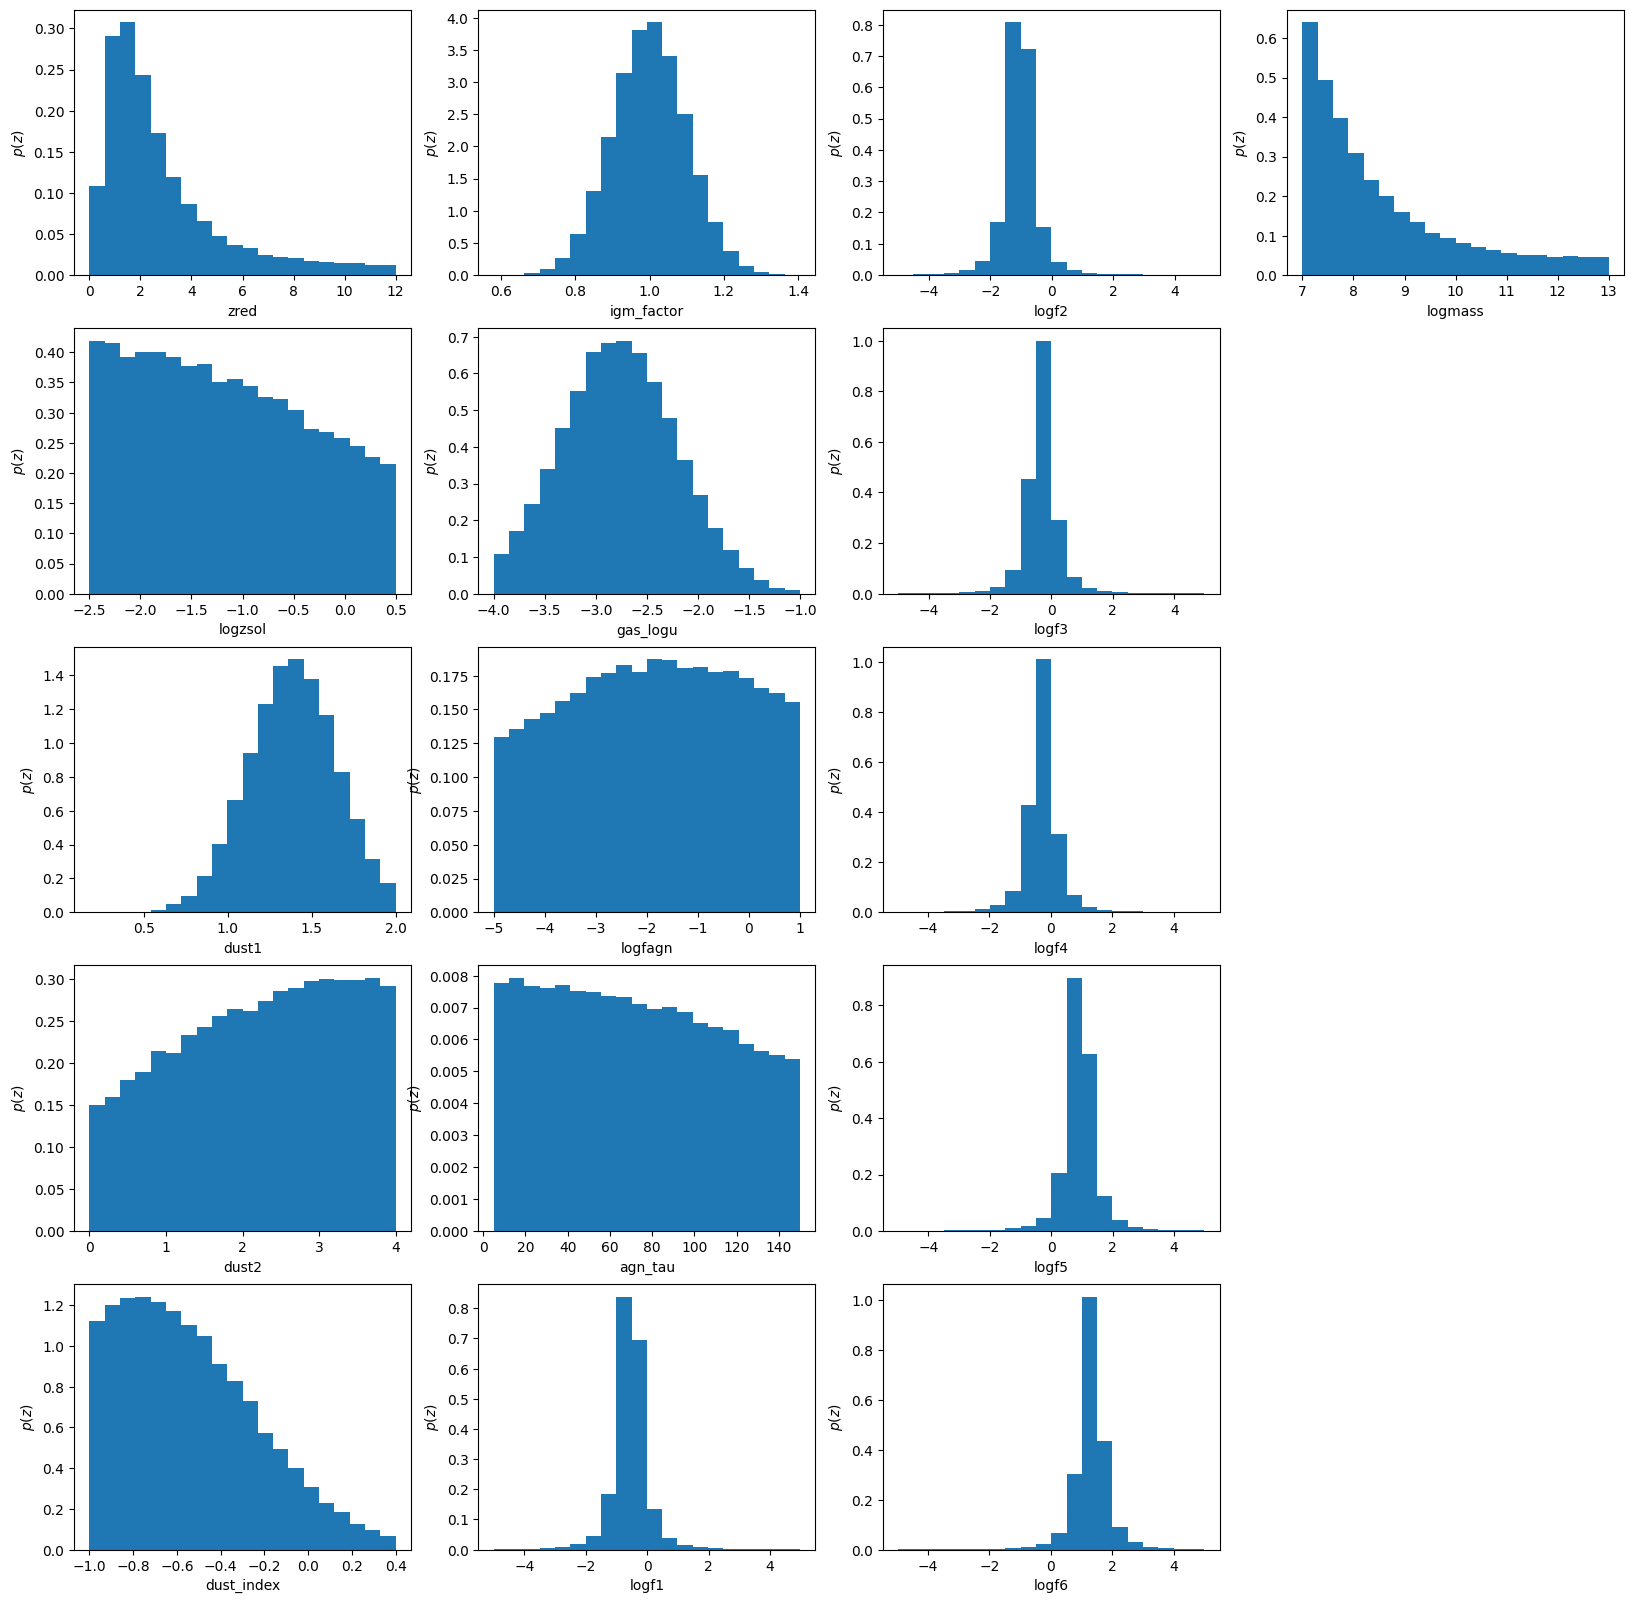

In [7]:
sps_parameters = pop.generate_sps_parameters(50000, prior_parameters[np.random.randint(0, 1000),:], redshift_mass_prior_parameters)
pop.plot_galaxy_population(sps_parameters, rows=5, nbins=20)

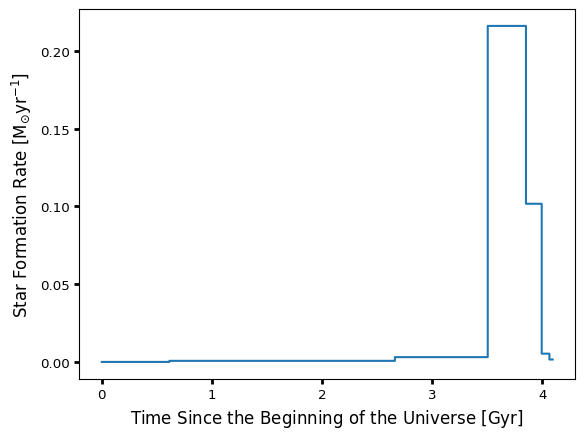

In [8]:
sfh.sps_parameters_to_sfh(sps_parameters[0,:], sfh.default_agebins())

8.94648889761946e-05 8.946488693170306e-05 93975656.96852508 93975656.96852507


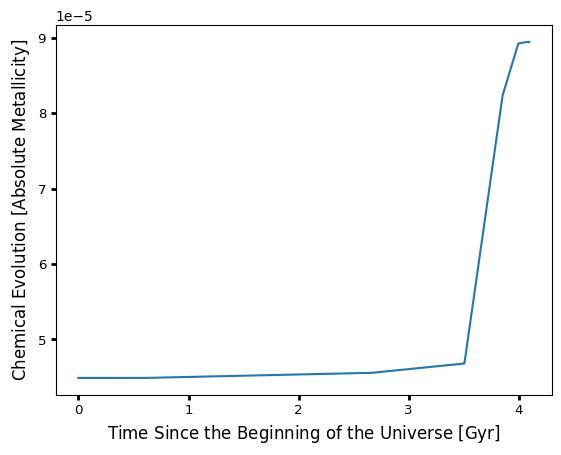

In [9]:
zh.sps_parameters_to_zhistory(sps_parameters[0,:], sfh.default_agebins())

In [10]:
photometry = sps.simulate_photometry(sps_parameters, "lsst", imf=1, dust=0, nebem=False, zhistory=False)

Starting Run 1/3
libraries:  (b'mist', b'miles', b'DL07')
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
Run 1/3 Complete
Complete


In [16]:
lbg_dropouts, params = noise.get_noisy_magnitudes(sps_parameters, photometry, random_state=42, return_params=True)
lbg_photometry = sel.colours(lbg_dropouts)
uparams, gparams, rparams = nz.apply_cuts(lbg_photometry, return_all_params=True)
gparams.shape

(149, 16)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


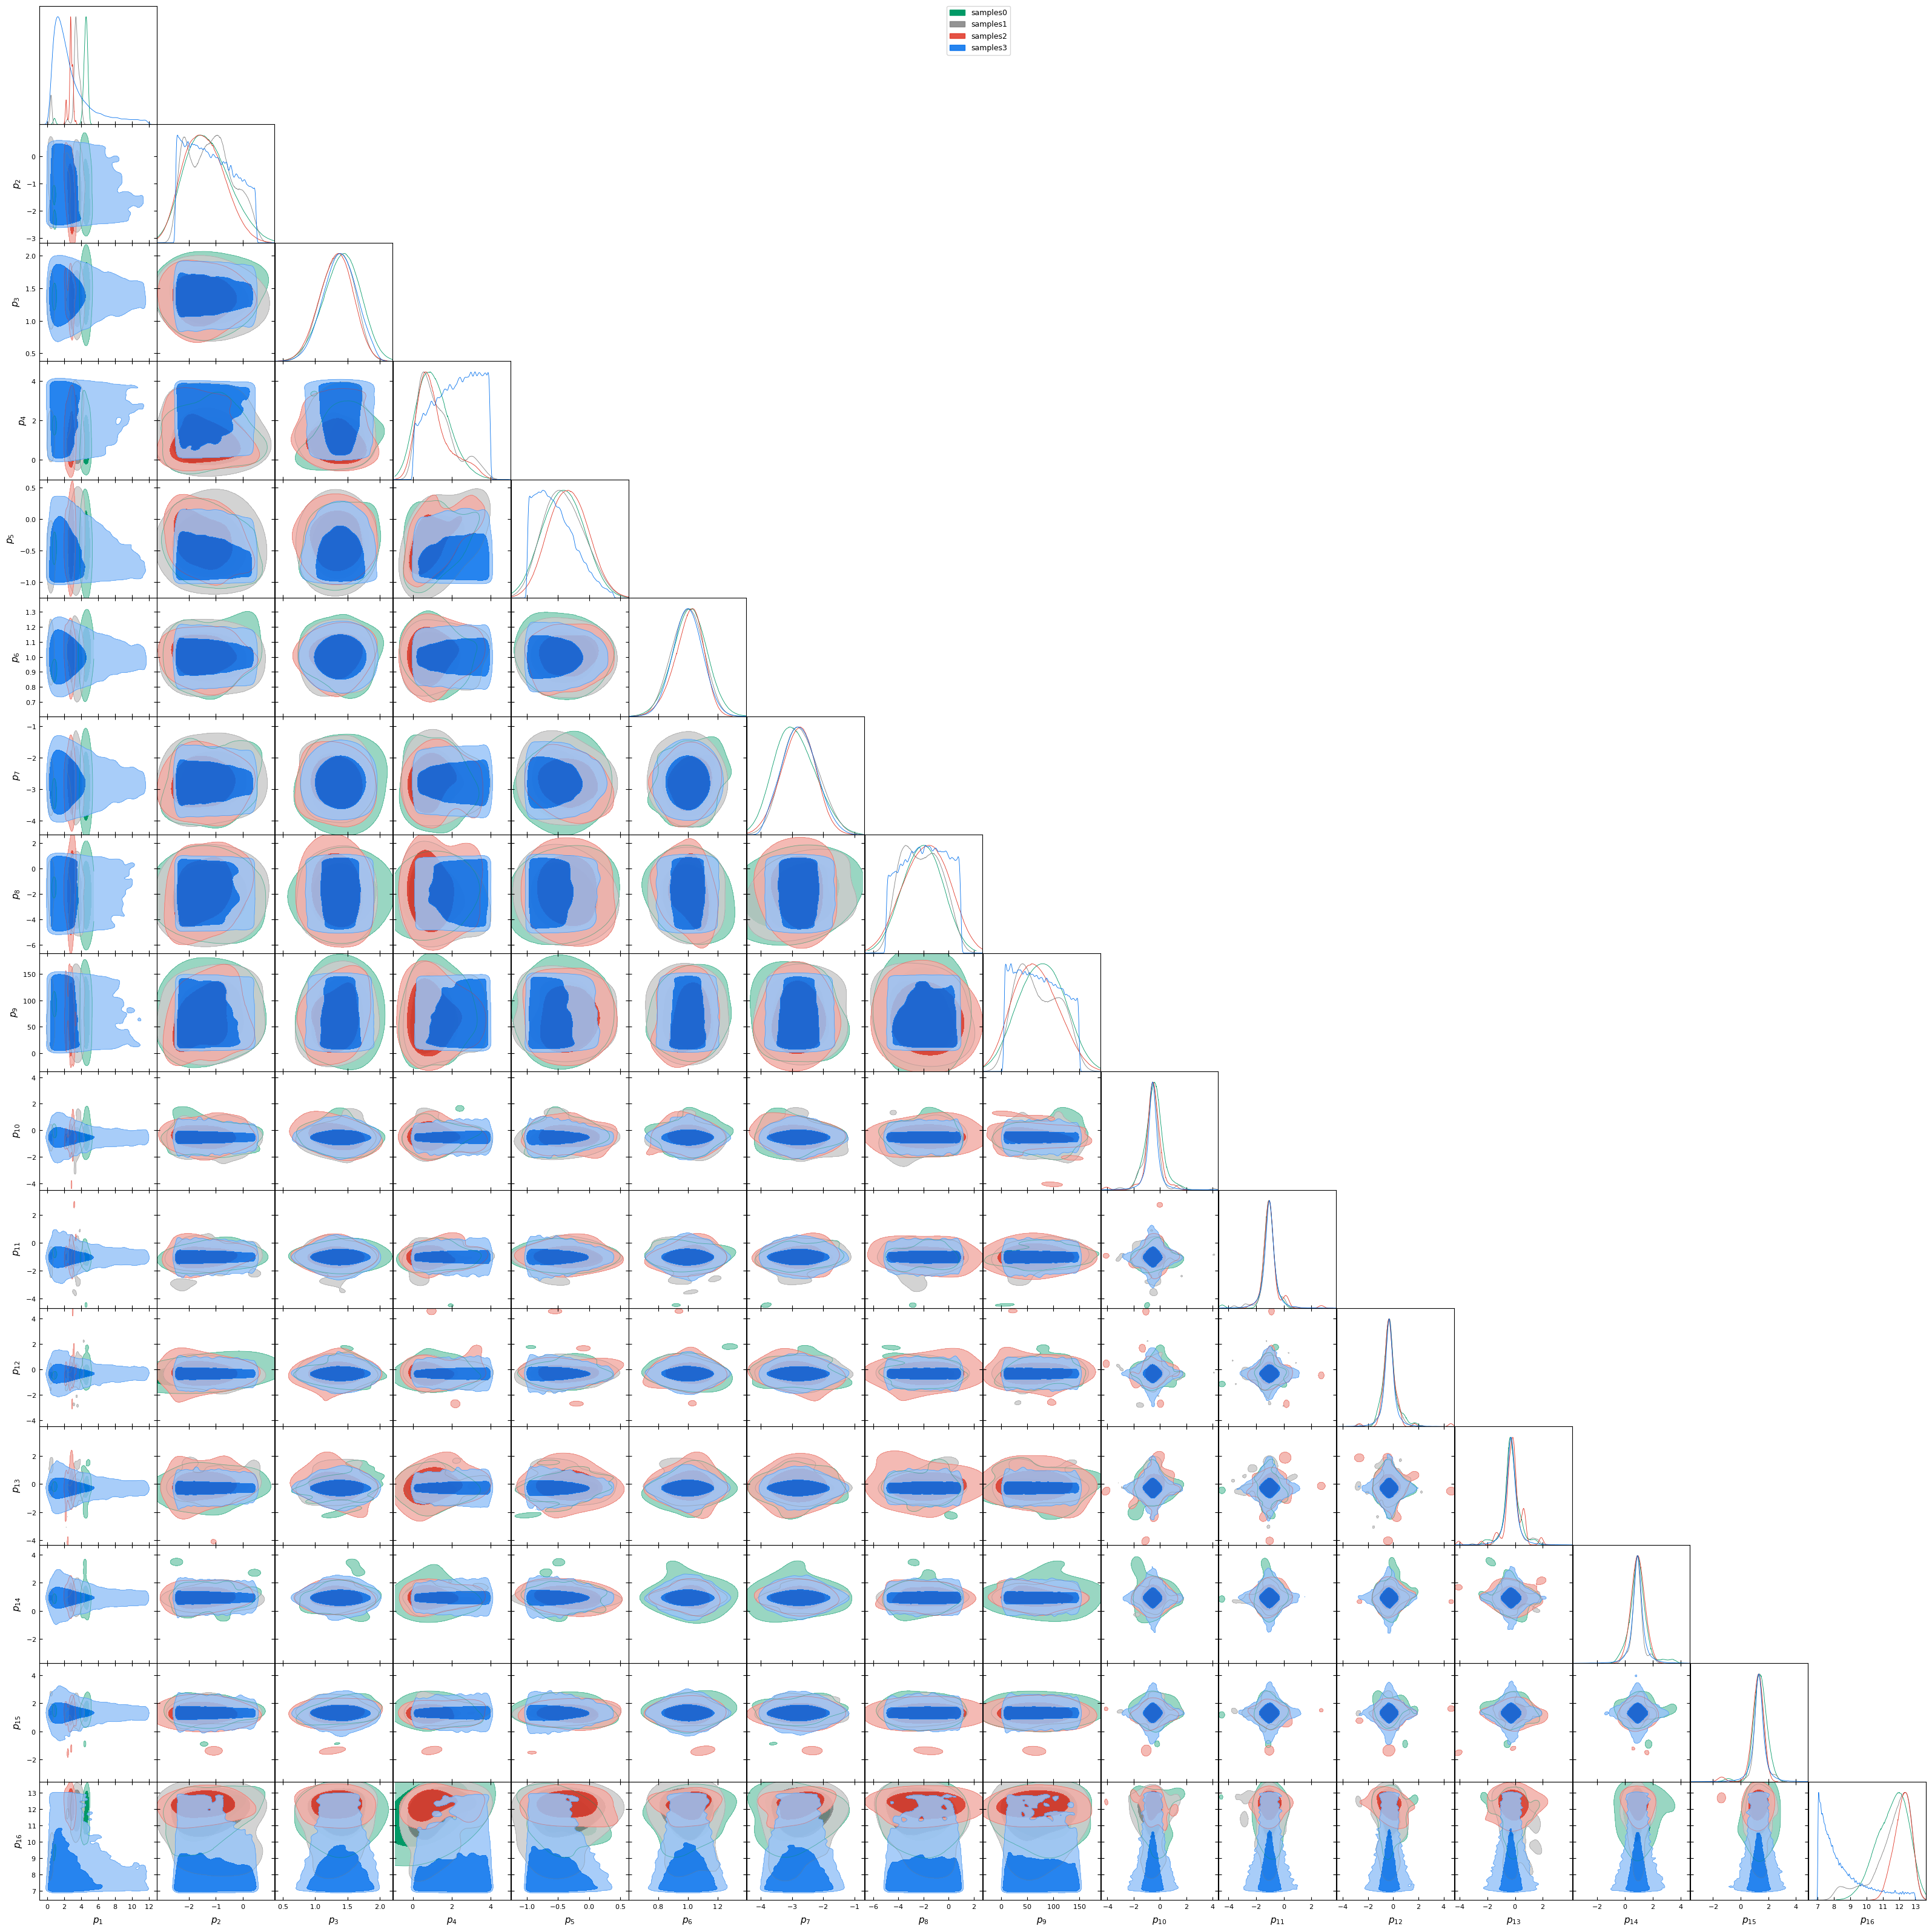

In [18]:
g = plots.get_subplot_plotter()
samples = np.copy(sps_parameters)
usamples = np.copy(uparams)
gsamples = np.copy(gparams)
rsamples = np.copy(rparams)
samples[:,-1] = np.log10(samples[:, -1])
samples[:,7] = np.log10(samples[:, 7])
usamples[:,-1] = np.log10(usamples[:, -1])
usamples[:,7] = np.log10(usamples[:, 7])
gsamples[:,-1] = np.log10(gsamples[:, -1])
gsamples[:,7] = np.log10(gsamples[:, 7])
rsamples[:,-1] = np.log10(rsamples[:, -1])
rsamples[:,7] = np.log10(rsamples[:, 7])

s1 = MCSamples(samples=samples)
s2 = MCSamples(samples=usamples)
s3 = MCSamples(samples=gsamples)
s4 = MCSamples(samples=rsamples)
g.triangle_plot([s4, s3, s2, s1], filled=True)

In [19]:
np.save("spsparams.npy", sps_parameters)
np.save("uparams.npy", uparams)
np.save("gparams.npy", gparams)
np.save("rparams.npy", rparams)